In [1]:
# ------------------------------------------------------------------------------ #
# @Author:        F. Paul Spitzner
# @Email:         paul.spitzner@ds.mpg.de
# @Created:       2024-05-15 20:53:24
# @Last Modified: 2024-05-15 21:00:21
# ------------------------------------------------------------------------------ #
# This notebook does the model comparison and creates the panel for fig. 2.
# it needs the idata traces from `bayesian_analysis.ipynb`
# Preprocessing / Setup in the first cell is the same in both notebooks.
# ------------------------------------------------------------------------------ #

import os
import pymc as pm
import nutpie
import numpy as np
import pandas as pd
import arviz as az
import sys

import logging

logging.basicConfig(
    format="%(asctime)s | %(levelname)-8s | %(name)-s | %(funcName)-s | %(message)s",
    level=logging.WARNING,
)
log = logging.getLogger("notebook")
log.setLevel("DEBUG")

extra_path = os.path.abspath("../")
sys.path.append(extra_path)
log.info(f"project directory: {extra_path}")

from ana import utility as utl
from ana import plot_helper as ph
from ana import bayesian_models as bm

ph.log.setLevel("DEBUG")
utl.log.setLevel("DEBUG")


data_dir = os.path.abspath("/Users/paul/para/5_Archive/information_timescales/repo/gnode.nosync/experiment_analysis/dat")


WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
2024-05-21 12:45:33,091 | INFO     | notebook | <module> | project directory: /Users/paul/para/5_Archive/information_timescales/repo/_latest/experiment_analysis


In [2]:
# Lets start with a bit of exploration:
# linear model
idata_lm = az.from_netcdf(f"{data_dir}/bayes_cortex_lm_tau_R_natural_movie_three.nc")
# structure group model
idata_sgm = az.from_netcdf(f"{data_dir}/bayes_cortex_sgm_tau_R_natural_movie_three.nc")
idata_sgm

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> observed_data

Warmup iterations saved (warmup_*).

In [3]:
idata_lm

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> observed_data

Warmup iterations saved (warmup_*).

In [4]:
comparison = az.compare(
    {"linear model": idata_lm, "structure groups": idata_sgm},
)
comparison

rank     elpd_loo      p_loo  elpd_diff    weight  \
linear model         0 -6396.506477  47.915014   0.000000  0.777679   
structure groups     1 -6407.145322  47.070785  10.638845  0.222321   

                         se       dse  warning scale  
linear model      62.651428  0.000000    False   log  
structure groups  62.494094  6.235137    False   log

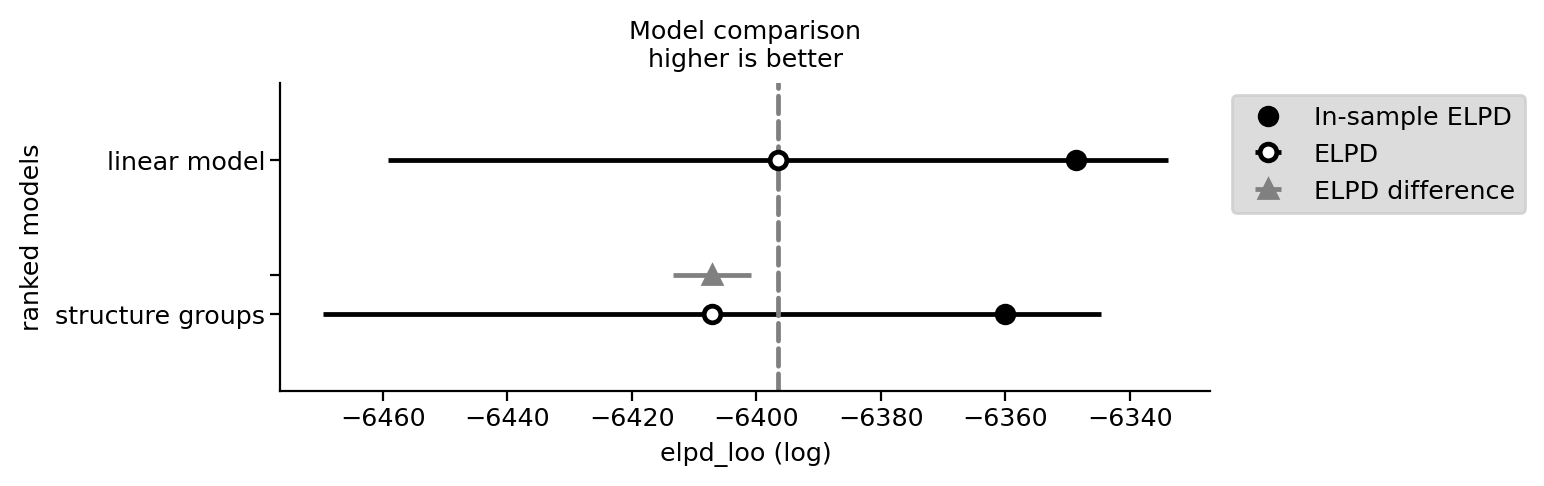

In [5]:
az.plot_compare(comparison, insample_dev=True, plot_ic_diff=True, plot_standard_error=True);

In [6]:
comparison["elpd_loo"]

linear model       -6396.506477
structure groups   -6407.145322
Name: elpd_loo, dtype: float64

In [7]:
loo_lm = az.loo(idata_lm, pointwise=True)
loo_sgm = az.loo(idata_sgm, pointwise=True)

In [8]:
obs = 'loo_i'
print(f"shape: {loo_lm[obs].shape}")
print(f"lm: {np.sum(loo_lm[obs]).values:.1f}")
print(f"sgm: {np.sum(loo_sgm[obs]).values:.1f}")
diff = loo_lm[obs] - loo_sgm[obs]
print(f"diff: {np.sum(diff).values:.1f}")
print(f"se: {np.sqrt(len(diff) * np.var(diff)).values:.1f}")

shape: (4758,)
lm: -6396.5
sgm: -6407.1
diff: 10.6
se: 6.2


In [9]:
# precompute LOO for all models and stimuli

from itertools import product
from tqdm.notebook import tqdm

models = ['sgm', 'lm']
measures = ["tau_double", "tau_R", "R_tot"]
stimuli = ["natural_movie_three", "spontaneous", "natural_movie_one_more_repeats"]

combinations = list(product(measures, stimuli, models))
loos = dict()

for meas, stim, model in tqdm(combinations):
    idata = az.from_netcdf(f"{data_dir}/bayes_cortex_{model}_{meas}_{stim}.nc")
    loos[f"{model}_{meas}_{stim}"] = az.loo(idata, pointwise=True)

  0%|          | 0/18 [00:00<?, ?it/s]

stim='natural_movie_three' meas='tau_double', np.sum(diff)=12.79
stim='natural_movie_three' meas='tau_R', np.sum(diff)=10.64
stim='natural_movie_three' meas='R_tot', np.sum(diff)=-1.97
stim='spontaneous' meas='tau_double', np.sum(diff)=12.92
stim='spontaneous' meas='tau_R', np.sum(diff)=14.65
stim='spontaneous' meas='R_tot', np.sum(diff)=-0.19
stim='natural_movie_one_more_repeats' meas='tau_double', np.sum(diff)=14.87
stim='natural_movie_one_more_repeats' meas='tau_R', np.sum(diff)=10.41
stim='natural_movie_one_more_repeats' meas='R_tot', np.sum(diff)=2.78


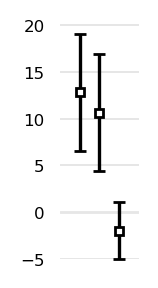

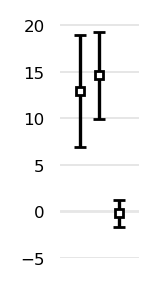

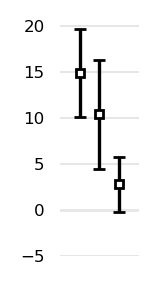

In [10]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from bitsandbobs.plt import set_size

matplotlib.rcParams["savefig.facecolor"] = (0.0, 0.0, 0.0, 0.0)  # transparent figure bg
matplotlib.rcParams["axes.facecolor"] = (1.0, 0.0, 0.0, 0.0)
matplotlib.rcParams["xtick.labelsize"]= 6
matplotlib.rcParams["ytick.labelsize"]= 6


# stim = "spontaneous"
# stim = "natural_movie_three"
# stim = "natural_movie_one_more_repeats"

for stim in stimuli:
    _, ax = plt.subplots();
    for mdx, meas in enumerate(measures):
        # this is the same what arviz.compare does, but I decided to not use az.compare.
        # because it ranks the models, but we always want to have "linear_model - structure_groups".
        # 'loo_i' gives us the array of the leave-one-out samples, with length rows in df
        diff = (
            loos[f"lm_{meas}_{stim}"]["loo_i"].values
            - loos[f"sgm_{meas}_{stim}"]["loo_i"].values
        )
        ax.errorbar(
            x=mdx + 1,
            y=np.sum(diff),
            yerr=np.sqrt(len(diff) * np.var(diff)),
            label=f"{meas}",
            fmt = "s",
            # markeredgewidth = 0.0,
            markersize = 3.0,
            markerfacecolor = 'white',
            ecolor = 'black',
            color = "black",
            elinewidth = 1.2,
            capsize = 2,
            clip_on=False,
        )
        print(f"{stim=} {meas=}, {np.sum(diff)=:.2f}")

    ax.set_xticks([])
    ax.set_ylim(-5, None)
    # yticks = [25, 20, 15, 10, 5, 0]
    # ax.set_yticks(yticks)
    for y in ax.get_yticks():
        ax.axhline(y, ls="-", lw=1.0 if y == 0 else 0.7, zorder=0, color="#E6E6E6")
    ax.set_xlim(0, 4)
    sns.despine(ax=ax, trim=False, bottom=True)
    # ax.set_ylabel("ELPD difference")
    ax.spines['left'].set_visible(False)
    ax.yaxis.set_ticks_position('none')

    set_size(ax, w=1.0, h=3.0, b=0.1, l=0.7, t=0.1)
    # ax.get_figure().savefig(f"../img/model_comparison_{stim}_all_measures.pdf")

In [11]:
%load_ext watermark
%watermark -v --iversions --packages nutpie,pymc,arviz

Python implementation: CPython
Python version       : 3.11.9
IPython version      : 8.22.2

nutpie: 0.10.0
pymc  : 5.14.0
arviz : 0.18.0

matplotlib    : 3.8.4
IPython       : 8.22.2
seaborn       : 0.11.2
sqlite3       : 2.6.0
pymc          : 5.14.0
arviz         : 0.18.0
logging       : 0.5.1.2
nutpie        : 0.10.0
numpy         : 1.24.4
sys           : 3.11.9 | packaged by conda-forge | (main, Apr 19 2024, 18:34:54) [Clang 16.0.6 ]
prompt_toolkit: 3.0.42
pandas        : 2.0.3



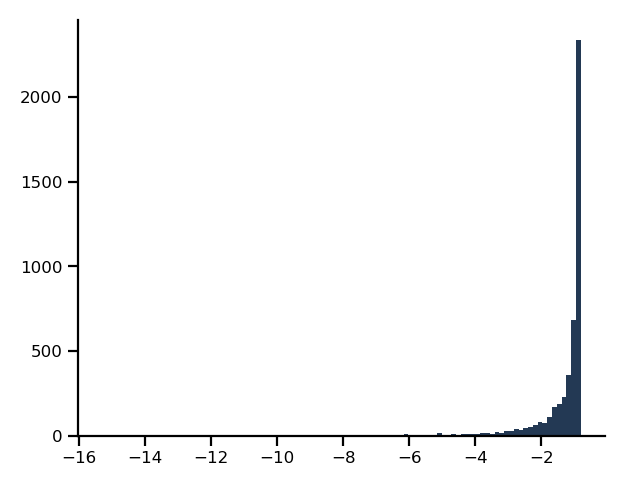

In [12]:
import matplotlib.pyplot as plt


meas = "tau_double"
# stim = "natural_movie_one_more_repeats"
stim = "natural_movie_three"


plt.hist(
    loos[f"sgm_{meas}_{stim}"]["loo_i"].values,
    bins=100,
);

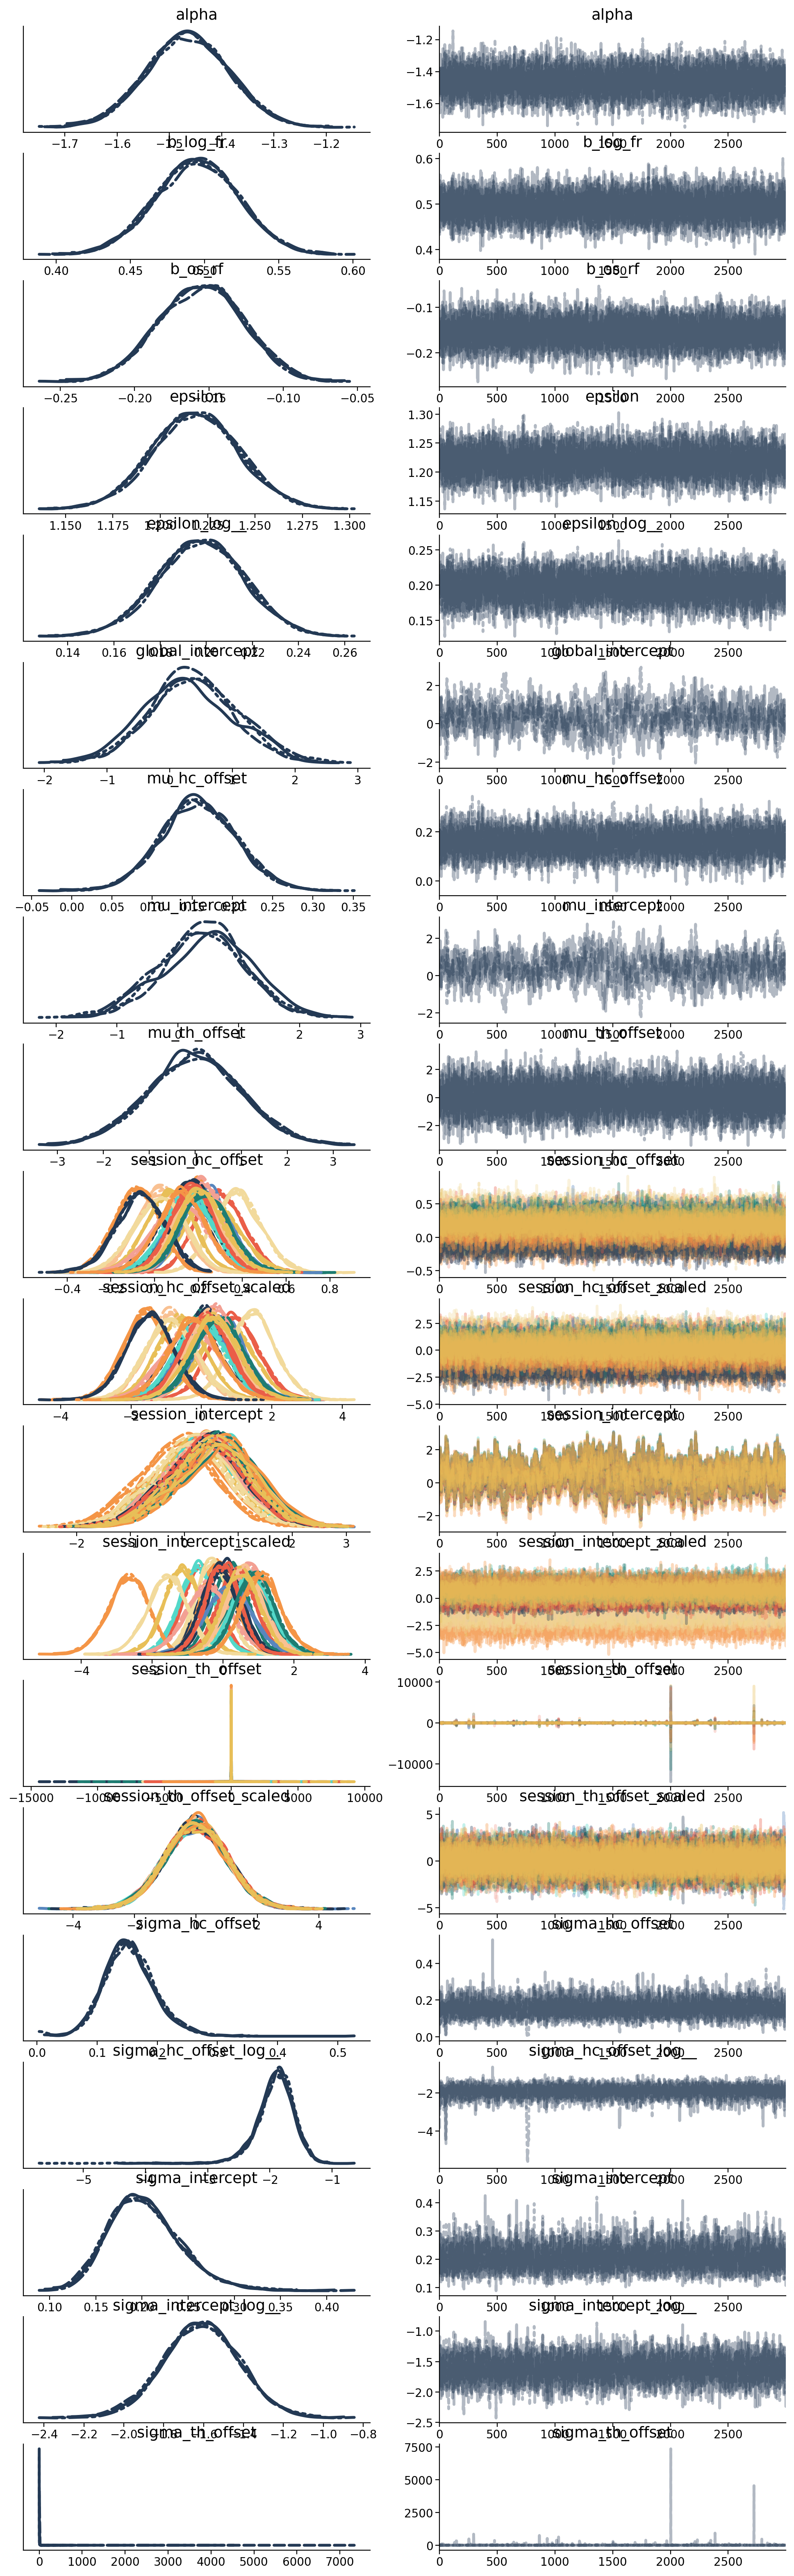

In [13]:
import arviz as az
idata = az.from_netcdf(f"{data_dir}/bayes_cortex_sgm_tau_double_natural_movie_one_more_repeats.nc")
az.plot_trace(idata);